In [6]:
from neuralop.models import FNO
import torch
import pathlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
from IPython.display import HTML

from acoustic_no.cno.cno_model import CNOModel
from acoustic_no.data import ShuffledAcousticDataset

In [2]:
# Use the GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load the dataset
dataset = ShuffledAcousticDataset(
    dataset_dir=pathlib.Path("/opt/dlami/nvme/acoustic-no/testing/processed"),
)
print(f"Dataset size: {len(dataset)}")

Dataset size: 1024


In [5]:
depth = dataset.depth

In [13]:
model = CNOModel(
    input_channels=depth * 3 + 1,
    hidden_channels=[64, 64],
    layer_sizes=[2, 2],
    output_channels=depth
)
model.load_state_dict(
    torch.load(
        "../models/cno/best_model.pth",
        map_location=device
    )
)
model.to(device)

CNOModel(
  (lifting): Conv2d(193, 64, kernel_size=(1, 1), stride=(1, 1))
  (downsample_blocks): ModuleList(
    (0): DownsampleBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ActivationLayer(
        (activation): ReLU()
      )
    )
  )
  (upsample_blocks): ModuleList(
    (0): UpsampleBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ActivationLayer(
        (activation): ReLU()
      )
    )
  )
  (cno_layers): ModuleList(
    (0-1): 2 x CNOLayer(
      (residual_blocks): ModuleList(
        (0-1): 2 x ResidualBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ActivationLayer(
            (activation): ReLU()
          )
        )
      )
      (identity_block): IdentityBlock(
        (conv): Conv2d(64, 64, kernel_size=

In [14]:
data = dataset[0]
x = data["x"].unsqueeze(0).to(device)
y = data["y"]
y_pred = model(x).squeeze(0).cpu().detach().numpy()
print(f"Input shape: {x.shape}")
print(f"Output shape: {y_pred.shape}")
print(f"Target shape: {y.shape}")

Input shape: torch.Size([1, 193, 64, 64])
Output shape: (64, 64, 64)
Target shape: torch.Size([64, 64, 64])


Animation Progress:   0%|          | 0/64 [00:00<?, ?step/s]

MovieWriter imagemagick unavailable; using Pillow instead.


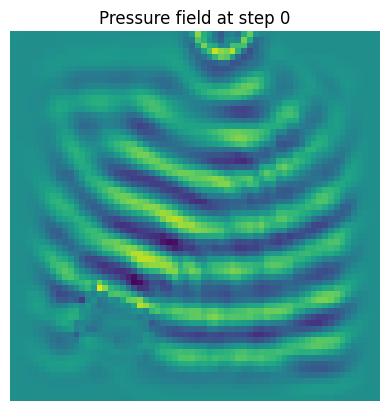

In [15]:
# Tqdm progress bar for the simulation
pbar = tqdm(total=depth, desc="Animation Progress", unit="step")

# Generate the animation for the pressure field.
def update(frame):
    ax.clear()
    im = ax.imshow(
        y_pred[frame].T,
        interpolation='nearest',
        vmin=-10.0,
        vmax=10.0
    )
    ax.set_title(f'Pressure field at step {frame}')
    ax.axis('off')
    # Update the progress bar
    pbar.update(1)
    # Close the progress bar when done
    if frame == depth - 1:
        pbar.close()
    return [im]

fig, ax = plt.subplots()

# Wrap the animation generation with tqdm for progress tracking
ani = FuncAnimation(
    fig,
    update,
    frames=range(depth),
    interval=1000 / 60,
    blit=False,
    repeat=True,
)

# Save gif
ani.save("pred_pressure_field.gif", fps=60, writer='imagemagick')
# Display the animation in the notebook
HTML(ani.to_jshtml())